In [2]:
!pwd

/home/reza/erq/color-color


In [6]:
from astropy.table import Table, Column
import time
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import sys
from scipy.stats import kde
from tqdm import tqdm, notebook
import sys
sys.path.insert(0, '../Modules')
from scipy import interpolate
# import pyfits
from numpy import *
import math
import scipy.ndimage
from scipy import interpolate
from numpy import nanmean
from numpy import nanmedian
from readSDSSspectrafast import *
import matplotlib.pylab as plt
import numpy as np
from scipy import ndimage
from line_db import line_db
import os
# Reading data
# smp=Table.read('/home/reza/erq/sampling/org_sample2.fits')
smp=Table.read('../LumMatch/LumMatch.fits')
W3_0=smp['ABw3']
iW3_0 = smp['i-w3']
kt80_0= smp['kurt80_gf']
rew_0 = smp['rew_gf']
rew_0  = np.log10(rew_0)
frat_0 = smp['frat_nv/civ']
fwhm_0 = smp['fwhm_gf']
rw3_0=smp['r-w3']
rz_0=smp['r-z']
iz_0 = iW3_0 - rw3_0 + rz_0
Lum_0 = smp['Lum']
z_dr12=smp['z_dr12']
nqsos=len(iW3_0)
smp.columns

print(nqsos)

30592


In [7]:
def PDF_2D(X, Y, cond_1, cond_2, nGrid):
    """ counts the number of objects in each cell
    and if the objects satisfies the criteria 
    label it as CERQ and gives out the pattern"""
    import numpy as np

    x_bin = np.linspace(np.min(X[:,0]), np.max(X[:,0]), nGrid)
    y_bin = np.linspace(np.min(X[:,1]), np.max(X[:,1]), nGrid)
    PDF_cond= np.zeros([nGrid, nGrid])
    PDF= np.zeros([nGrid, nGrid])
    for i in range(len(X)):
        for k in range(nGrid-1):
            for n in range(nGrid-1):
                if(X[i,0]>= x_bin[k] and  X[i,0]<= x_bin[k+1] and X[i,1]>= y_bin[n] and X[i,1]<= y_bin[n+1]):
                    PDF[n,k] +=1
                    if (Y[i,0]>cond_1 and Y[i,1]>cond_2):
                        PDF_cond[n,k] +=1
    y=np.zeros([nGrid, nGrid])
    for k in range(nGrid):
        for n in range(nGrid): 
            if(PDF[n,k]>0):
                y[n,k] = PDF_cond[n,k]/PDF[n,k]*100
                    
    return y, PDF_cond

In [8]:
#  ---------r-z sample
z_cut =2.7
W3_rz= W3_0[z_dr12<=z_cut]
iW3_rz = iW3_0[z_dr12<=z_cut]
kt80_rz= kt80_0[z_dr12<=z_cut]
rew_rz = rew_0[z_dr12<=z_cut]
rew_rz  = 10**rew_rz
frat_rz = frat_0[z_dr12<=z_cut]
fwhm_rz = fwhm_0[z_dr12<=z_cut]
rw3_rz=rw3_0[z_dr12<=z_cut]
rz_rz=rz_0[z_dr12<=z_cut]
iz_rz = iW3_rz - rw3_rz + rz_rz
Lum_rz = Lum_0[z_dr12<=z_cut]
z_dr12_rz = z_dr12[z_dr12<=z_cut]

In [9]:
#  colorbar of REW 
# %matplotlib
n_sigma=100 #(rz_rz<=np.median(rz_rz)+n_sigma*np.std(rz_rz)) &
mask =  (rz_rz>=np.median(rz_rz)-n_sigma*np.std(rz_rz)) # & (iW3_rz<=np.median(iW3_rz)+n_sigma*np.std(iW3_rz)) & (iW3_rz>=np.median(iW3_rz)-n_sigma*np.std(iW3_rz))
rz_rz_center = rz_rz[mask]
iW3_rz_center = iW3_rz[mask]
rew_rz_center = rew_rz[mask]
kt80_rz_center = kt80_rz[mask]
print(len(iW3_rz_center), len(rz_rz_center))
print(len(iW3_rz))

21838 21838
21838


In [10]:
np.linspace(0.29, 0.33, 5)

array([0.29, 0.3 , 0.31, 0.32, 0.33])

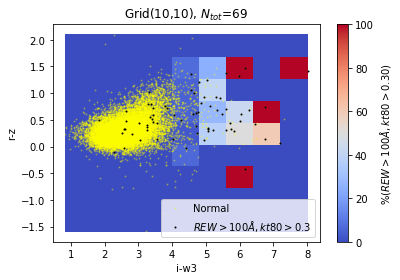

In [39]:
from matplotlib import ticker
NG=10
X=np.array(list(zip(iW3_rz_center,rz_rz_center))) 
Y = np.array(list(zip(rew_rz_center, kt80_rz_center)))
REW_limit = [100] #np.linspace(80, 120, 5)
kt80_limit = [0.30] #np.linspace(0.29, 0.33, 5)
for nGrid in [NG]:
    for cond1 in REW_limit:
        for cond2 in kt80_limit:

            pdf, pdf_ERQ  = PDF_2D(X, Y, cond1, cond2, nGrid)

            from matplotlib import colors
            # plt.imshow(flagN1, cmap='coolwarm', origin='lower', alpha=.7)
            # plt.grid(which='major', axis='both', linestyle='-', color='k', linewidth=0.5)
            x=np.linspace(min(iW3_rz_center),max(iW3_rz_center),nGrid)
            y= np.linspace(min(rz_rz_center),max(rz_rz_center),nGrid)
            xx, yy = np.meshgrid(x,y)
            plt.pcolormesh(xx, yy, pdf,cmap='coolwarm' )
            # plt.xticks(np.arange(0,nGrid), fontsize=6);
            # plt.yticks(np.arange(0,nGrid) , fontsize=6);
            # plt.grid('on')
#             plt.axvline(x=4.6, ls='--', lw=2, c='white' )
            plt.ylabel('r-z')
            plt.xlabel('i-w3')
            # plt.axhline(y=2, xmin=0.5, ls='--')

            cb = plt.colorbar(label=r'%' + r'$(REW>%d\AA, kt80>%.2f)$' %(cond1, cond2))
#             tick_locator = ticker.MaxNLocator(nbins=np.max(pdf))
#             cb.locator = tick_locator
#             cb.update_ticks()

        #     plt.scatter(data[:,0], data[:,1])
            # plt.scatter(medCERQ[0], medCERQ[1], marker='x', s=100, c='white')
            plt.title(r'Grid(%d,%d), $N_{tot}$=%d' %(nGrid, nGrid, np.sum(pdf_ERQ)))
            plt.scatter(iW3_rz, rz_rz, alpha=0.3, s=1, c='yellow', label='Normal')
            plt.scatter(iW3_rz[(rew_rz>100) & (kt80_rz>0.3)], rz_rz[(rew_rz>100) & (kt80_rz>0.3)],  s=1, c='black', 
                        label=r'$REW>100\AA, kt80>0.3$')
            plt.legend()
            plt.savefig('PDF-rew.pdf')
            plt.show()